In [0]:
project_name = 'test_project_1'
#permissions='default'
permissions='fulldata'

In [0]:
%run /Snippets/header_008

PROJECT DETAILS:
Project identifier: test_project_1
Cluster data access level: fulldata


EXECUTION DETAILS:
Spark version: 11.3.x-scala2.12, 
Cluster Node Type: i3.xlarge, 
Driver Node Type: c4.2xlarge, 
Worker Node Type: i3.xlarge


DATA SNAPSHOT DETAILS:
This notebook uses the latest snapshot date for this version: "v008.20231003094404/", (03 October 2023)

 The following are the Scopus snapshot dates available for datasets at v008:
['v008.20220314092239/', 'v008.20220906063204/', 'v008.20221021151538/', 'v008.20230509104116/', 'v008.20230821105000/', 'v008.20231003094404/']
(If you want to use a different snapshot, in the first cell of your notebook, set the variable `custom_snapshot_date` to one of the options listed above (string data type))



DATA SAMPLE DETAILS:
Setting paths to run on full datasets (100% Scopus publication volume)


In [0]:
%pip install markupsafe==2.0.1
%pip install rpy2

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
  ERROR: Command errored out with exit status 1:
   command: /local_disk0/.ephemeral_nfs/envs/pythonEnv-56054b8c-ce8a-4704-b313-1d7f8c93fee4/bin/python /local_disk0/.ephemeral_nfs/envs/pythonEnv-56054b8c-ce8a-4704-b313-1d7f8c93fee4/lib/python3.9/site-packages/pip/_vendor/pep517/in_process/_in_process.py get_requires_for_build_wheel /tmp/tmpwfzi7b4n
       cwd: /tmp/pip-install-o1m2mmxa/rpy2_b52ec08cec6547d0ba74e0ca4b9bba09
  Complete output (16 lines):
  Traceback (most recent call last):
    File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-56054b8c-ce8a-4704-b313-1d7f8c93fee4/lib/python3.9/site-packages/pip/_vendor/pep517/in_process/_in_process.py", line 349, 

In [0]:
import pandas as pd
import pyspark.sql.functions as F
def first(lst):
  return lst[0]
def extract_publication_info(newdf):
  #newdf = df_ani.limit(50)
  newdf = newdf.select('doi','Eid','year','Au','Au_Af','Au_cors','publication_type','openaccess','issn','source','news_cnt','correspondence','Af')


  newdf = newdf.withColumn('Au1', first(newdf['Au']))



  newdf = newdf.withColumn('Au2', F.element_at(newdf['Au'], -1))

  newdf = newdf.withColumn('num_au', F.size(newdf['Au']))

  newdf = newdf.withColumn('Au1_id', F.col('Au1').getItem('auid'))

  newdf = newdf.withColumn('Au2_id', F.col('Au2').getItem('auid'))

  newdf = newdf.withColumn('Au_cor_id', F.col('Au_cors').getItem('auid'))
  #newdf = newdf.withColumn('Au_cor_name', F.col('Au_cors').getItem('given_name'))
  #newdf = newdf.withColumn('cor1_given_name', first(newdf['Au_cor_name']))

  newdf = newdf.withColumn('cor_seq', F.col('Au_cors').getItem('Authorseq'))
  newdf = newdf.withColumn('cor_seq_first', first(newdf['cor_seq']))

  newdf = newdf.withColumn('auth_seq', F.col('Au_Af').getItem('Authorseq'))
  newdf = newdf.withColumn('aff_seq', F.col('Au_Af').getItem('affiliation_seq'))
  newdf = newdf.withColumn("auth_pos", F.expr("array_position(auth_seq, cor_seq_first)"))

  newdf = newdf.withColumn("auth_pos", newdf["auth_pos"].cast(IntegerType()))  
  #newdf = newdf.filter(F.col('aff_seq').isNotNull())
  newdf = newdf.filter(F.col('auth_pos') != 0)
  newdf = newdf.withColumn("aff", F.element_at(newdf['aff_seq'], newdf['auth_pos']))
  newdf = newdf.withColumn("aff_val", F.element_at(newdf['Af'], newdf['aff']))
  newdf = newdf.withColumn("cor_afid", F.col('aff_val').getItem('afid'))

  newdf = newdf.withColumn('given_seq', F.col('Au').getItem('given_name'))
  newdf = newdf.withColumn("cor1_given_name", F.element_at(newdf['given_seq'], newdf['cor_seq_first']))
  display(newdf.limit(10))

  return newdf
def get_smc_classification(newdf):
  df_smc_ani = spark.read.format("parquet").load(basePath+tablename_smc_complete)
  newdf2 = newdf.join(df_smc_ani,'Eid', 'inner')
  return newdf2

def get_gender(newdf):
  df_gender = spark.read.format("parquet").load(basePath+tablename_gender_inference)
  #non_null_count = newdf.where(F.col('Au1_id').isNotNull()).count()
  mergedf = df_gender.join(newdf, newdf.Au1_id == df_gender.auid, 'inner').select(
      df_gender.Inferred_Probable_Gender,newdf.doi,newdf.news_cnt,newdf.Au,newdf.Eid, newdf.year, newdf.publication_type,newdf.openaccess, newdf.issn, 
      newdf.num_au, newdf.Au1_id,newdf.Au2_id,newdf.Au_cor_id, newdf.srcid, newdf.subfield_article, newdf.subfield_journal, newdf.subfield_hybrid,newdf.correspondence,
      newdf.cor1_given_name, newdf.cor_afid)
  mergedf = mergedf.withColumnRenamed('Inferred_Probable_Gender', 'Au1_gender')

  mergedf2 = df_gender.join(mergedf, mergedf.Au2_id == df_gender.auid, 'inner').select(
      df_gender.Inferred_Probable_Gender, mergedf.doi,mergedf.news_cnt,mergedf.Au,mergedf.Eid, mergedf.year, mergedf.publication_type,mergedf.openaccess, mergedf.issn, 
      mergedf.num_au, mergedf.Au1_id,mergedf.Au2_id,mergedf.Au_cor_id, mergedf.srcid, mergedf.subfield_article, mergedf.subfield_journal, mergedf.subfield_hybrid, mergedf.Au1_gender,mergedf.correspondence,mergedf.cor1_given_name,mergedf.cor_afid)
  mergedf2 = mergedf2.withColumnRenamed('Inferred_Probable_Gender', 'Au2_gender')

  #mergedf2 = mergedf2.withColumn('no_cor', F.size(mergedf2['Au_cor_id']))
  #display("len os final4 ", mergedf2.count(),"\n")

  mergedf2 = mergedf2.withColumn('cor_au1', first(mergedf2['Au_cor_id']))

  #display(final_data4.limit(20))

  mergedf3 = mergedf2.filter(F.col('cor_au1').isNotNull())
  display("no of not null cor au",mergedf3.count(),"\n")

  mergedf4 = df_gender.join(mergedf3, mergedf3.cor_au1 == df_gender.auid, 'inner').select(
      df_gender.Inferred_Probable_Gender, mergedf3.doi,mergedf3.news_cnt,mergedf3.Au,mergedf3.Eid, mergedf3.year, mergedf3.publication_type,mergedf3.openaccess, mergedf3.issn, 
      mergedf3.num_au, mergedf3.Au1_id,mergedf3.Au2_id,mergedf3.Au_cor_id, mergedf3.srcid, mergedf3.subfield_article, mergedf3.subfield_journal, mergedf3.subfield_hybrid, mergedf3.Au1_gender,mergedf3.Au2_gender,mergedf3.cor_au1,mergedf3.correspondence,mergedf3.cor1_given_name, mergedf3.cor_afid)
  mergedf4 = mergedf4.withColumnRenamed('Inferred_Probable_Gender', 'cor_gender')

  return mergedf4

def merge_news_cnt(scop):
  scop = scop.filter(func.col('year') >= 2018)
  scop = scop.filter(func.col('year') <= 2022)
  df1 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/doi_news_final.csv")
  display("# doi data from crossref and altmetric ",df1.count(),"\n")
  df = scop.join(df1, 'doi','inner')
  df = df.withColumn("news_cnt", df["news_cnt"].cast(IntegerType()))
  return df

from pyspark.sql.functions import lower

df_ani = spark.read.format("parquet").load(basePath+tablename_ani)

display("len of df_ani ",df_ani.count(),"\n")
dd = df_ani.withColumn('language', first(df_ani['meta_language']))
d1 = dd.withColumn('language_s', lower(dd['language']))

d2 = d1.filter(func.col('language_s') == 'english')
display("len of df_ani in english ",d2.count(),"\n")

with_news = merge_news_cnt(d2)
display("merged data len between crossref and scopus ",with_news.count(),"\n")

newdf = extract_publication_info(with_news)

df_class = get_smc_classification(newdf)
final_data = get_gender(df_class)
display(final_data.count(),"\n")
final_data2 = final_data.dropna(subset=["doi"])
display(final_data2.count(),"\n")

##extracting sci_val topic for each publication
df_top_eids = spark.read.format("parquet").load(basePath+tablename_top_topic_eid)

final_data3 = final_data2.join(df_top_eids,'Eid','inner')
#display(final_data3.count())
display(final_data3.limit(10))


import pyspark.sql.functions as F
import pyspark.sql.column as C

def find_sjr(met,yy,yr):

  ylst = F.tolist(yy)

  #index = ylst.index(yr)
  #sjr = m[index]
  return m


df_sources = spark.read.format("parquet").load(basePath+tablename_sources)

data = final_data3.join(df_sources,'srcid','inner').select(df_sources.metrics_calculations,df_sources.sourcetitle,df_sources.openaccess_status,final_data3.srcid,final_data3.doi,final_data3.news_cnt,final_data3.year,
final_data3.publication_type, final_data3.issn, final_data3.num_au,final_data3.Au1_id, final_data3.subfield_article,final_data3.subfield_journal, final_data3.Au1_gender,final_data3.TopicId, 
final_data3.cor_gender,final_data3.cor_au1,final_data3.correspondence, final_data3.cor1_given_name, final_data3.cor_afid)

display("len of merged data between src ", data.count(),"\n")

data = data.withColumn('SJR_lst', F.col('metrics_calculations').getItem('SJR'))
data = data.withColumn('year_SJR', F.col('metrics_calculations').getItem('year'))

#data = data.withColumn('SJR', find_sjr(data['SJR_lst'],data['year_SJR'], data['year']))
data = data.withColumn("pos", F.expr("array_position(year_SJR, year)"))


data = data.withColumn("pos", data["pos"].cast(IntegerType()))  
data = data.withColumn("SJR", F.element_at(data['SJR_lst'], data['pos']))

data = data.withColumn('cor_af', first(data['correspondence']))
data = data.withColumn('cor_coun', F.col('cor_af').getItem('country'))



import pycountry
import pyspark.sql.functions as F

def convert_country_short_name(country_short_name):
  #country = pycountry.countries.get(alpha_2=country_short_name)
  if len(country_short_name) == 3:
    country = pycountry.countries.get(alpha_3=country_short_name)
  else:
    country = pycountry.countries.get(alpha_2=country_short_name)

  return country.name if country else None

@F.udf(returnType=F.StringType())
def my_udf(country_short_name):
  return convert_country_short_name(country_short_name)

data = data.filter(F.col('cor_coun').isNotNull())
data = data.withColumn("country_name", my_udf(data["cor_coun"]))
#un_full_coun = un_name.withColumn("country_name", my_udf(un_name["cor_coun"]))

df_ipr = spark.read.format("parquet").load(basePath+tablename_ipr)
data = data.join(df_ipr,[data.cor_afid == df_ipr.afid],'inner')
display(data.limit(10))

val_data = data.filter(func.col('cor_gender') != 'unknown')

#val_un = data.filter(func.col('cor_gender') == 'unknown')



display("len of data whose cor_gender is not unknown ",val_data.count(),"\n")

display(val_data.limit(5),"\n")


#val_un = data.filter(func.col('cor_gender') == 'unknown')
df_apr = spark.read.format("parquet").load(basePath+tablename_apr)
#un_full_coun = val_un.join(df_apr,val_un.cor_au1 == df_apr.auid,'inner')
un_full_coun = data.filter(func.col('cor_gender') == 'unknown')

display("len of unknown name ", un_full_coun.count(),"\n")
un_full_coun = un_full_coun.filter(F.col('cor1_given_name').isNotNull())
un_full_coun = un_full_coun.filter(F.col('country_name').isNotNull())
display("len of unknown name after dropping null country and given name ", un_full_coun.count(),"\n")
df_wos = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/wos_gender_firstname.csv")
#df_wos.printSchema()
#df_wos = df_wos.filter(func.col('country') == 'China')
newfile = un_full_coun.join(df_wos,[un_full_coun.cor1_given_name == df_wos.givenname,un_full_coun.country_name == df_wos.country],'inner')
display("len or merged gender with wos ", newfile.count(),"\n")

In [0]:
ddf2 = newfile.drop("cor_gender")
ddf3 = ddf2.withColumnRenamed("gender", "cor_gender")
#ddf3.printSchema()
#display(ddf3.select('cor_gender').distinct())
ddf4 = ddf3.select('srcid','openaccess_status','doi','news_cnt','year','issn','num_au','cor_gender','TopicId','Au1_gender','country_name','SJR','subfield_article','preferred_name','org_type', 'cor_au1').toPandas()
print(ddf4.head(5)) 

ddfx = val_data.select('srcid','openaccess_status','doi','news_cnt','year','issn','num_au','cor_gender','TopicId','Au1_gender','country_name','SJR','subfield_article','preferred_name','org_type','cor_au1').toPandas()
display(len(ddfx),"\n")
display(len(ddf4),"\n")
ddf = ddfx.append(ddf4, ignore_index = True)
display(len(ddf),"\n")

In [0]:
###new version
smc = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/sm_journal_classification.csv")
smc = smc.select('Domain_English','Field_English','SubField_English').toPandas()
smc = smc.dropna()
smc = smc.drop_duplicates()
print(len(smc))
smc['SubField_English'] = smc['SubField_English'].str.lower()
ddf['subfield_article'] = ddf['subfield_article'].str.lower()

#print(smc.dtypes)
total = smc.merge(ddf,left_on='SubField_English',right_on = 'subfield_article',how = 'inner')
print(len(total))

In [0]:
us = total[total['country_name'] == 'United States']
print(len(us))
us.to_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us_media_analysis.csv", index = False)

## merge the github and media file with us data

In [0]:
import pandas as pd

#load the saved us data
t = pd.read_csv("/dbfs/FileStore/shared_uploads/arabi2@wisc.edu/us_media_analysis.csv")

ff = t[t['news_cnt'] > 0]
print("number of unique doi in cited us data ",ff['doi'].nunique())
print("length of total data ",len(t))
print("length of total cited data ",len(ff))

#remove the retracted dois
ret = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/retrected_doi_wos.csv")
retracted = ret.select('doi').toPandas()
ids_to_remove = retracted['doi']
total = ff[~ff['doi'].isin(ids_to_remove)]
print("length of data after removing retracted ids ",len(total))
print("total mention ",total['news_cnt'].sum())
total = total.drop_duplicates(subset = ['doi'])
print("len of total after dropping duplicate doi ",len(total))

#merge dois with the media outlet names
m = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/doi_media_for_databricks.csv")
media = m.toPandas()
new_total =total.merge(media, on = ['doi'], how = 'inner') 
print(len(new_total))
print(new_total['doi'].nunique())
print(new_total['media'].nunique())
print(new_total.dtypes)
new_total = new_total.drop_duplicates(subset = ['doi','media'])
print("new_total after droppimg duplicate doi-media pair",len(new_total))


media_github = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/media_class_github3.csv")
media_github = media_github.toPandas()
media_github['media'] = media_github['media'].str.strip()
print("media github len ",len(media_github))
print(media_github['media'].nunique())
print(media_github['git'].nunique())


new_total['media'] = new_total['media'].str.strip()

merged = new_total.merge(media_github, on = ['media'], how = "inner")

print(len(merged))
print(merged['media'].nunique())
print(merged['git'].nunique())
print("xxx ", merged['doi'].nunique())

###new
merged = merged.drop_duplicates(subset = ['doi','git'])
print(len(merged))
merged = merged.drop_duplicates(subset = ['doi','media'])
print(len(merged))
print(merged['media'].nunique())
print(merged['git'].nunique())
print("xxx ", merged['doi'].nunique())


number of unique doi in cited us data  129439
length of total data  1014175
length of total cited data  129451
length of data after removing retracted ids  129440
total mention  1405538
len of total after dropping duplicate doi  129428
1405448
129428
5113
Domain_English        object
Field_English         object
SubField_English      object
srcid                  int64
openaccess_status     object
doi                   object
news_cnt               int64
year                   int64
issn                  object
num_au                 int64
cor_gender            object
TopicId                int64
Au1_gender            object
country_name          object
SJR                  float64
subfield_article      object
preferred_name        object
org_type              object
cor_au1                int64
media                 object
is_top                object
dtype: object
new_total after droppimg duplicate doi-media pair 1195149
media github len  708
708
647
366164
674
631
xxx  61596
361120


#### create table of doi, local_count, national_count, international_count

In [0]:
special = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/arabi2@wisc.edu/specialty_picked.csv")
special = special.toPandas()
print(special.dtypes)
print(special.tail(3))

##sanity check: special should have no intersection with merged
a = set(special['media'])
b = set(merged['media'])
#print(a.intersection(b))
for i in a:
    if i in b:
        print("ohh no")

media    object
count    object
dtype: object
              media count
102     livescience   812
103  chemistryviews   799
104       canaltech   787


In [0]:

special = special.drop(columns = ['count'], axis = 1)
special['cc'] = 1
print(special.head(10))
print(len(special))
print(special['media'].nunique())

                media  cc
0         eurekalert!   1
1       medicalxpress   1
2        sciencedaily   1
3      themedicalnews   1
4   medicalhealthnews   1
5         docwirenews   1
6            scienmag   1
7            medscape   1
8               drugs   1
9  technologynetworks   1
105
105


In [0]:
#create table od doi vs total_mention
import numpy as np
dummy = merged.copy()

nt = new_total.drop_duplicates(subset = ['doi','media'])
doi_total = nt['doi'].value_counts().reset_index()
doi_total.columns = ['doi','total_count']

#doi_total = dummy['doi'].value_counts().reset_index()
#doi_total.columns = ['doi','total_count']

#create table for special
sp = special.merge(nt, on = ['media'],how = 'inner')
print(len(sp)," ",sp['doi'].nunique()," ",sp['media'].nunique()," ***** ")
doi_sp = sp['doi'].value_counts().reset_index()
doi_sp.columns = ['doi','sp_count']
print(nt['doi'].nunique()," special ",sp['doi'].nunique())

#create table for doi vs local_mention
local = dummy[dummy['type'] == "local"]
doi_local = local['doi'].value_counts().reset_index()
doi_local.columns = ['doi','local_count']

#create table for doi vs national_mention
nat = dummy[dummy['type'] == "national"]
doi_nat = nat['doi'].value_counts().reset_index()
doi_nat.columns = ['doi','national_count']

#create table for doi vs international_mention
internat = dummy[dummy['type'] == "international"]
doi_internat = internat['doi'].value_counts().reset_index()
doi_internat.columns = ['doi','international_count']

merge1 = doi_total.merge(doi_local, on = ['doi'], how  = "left")

merge2 = merge1.merge(doi_nat, on = ['doi'], how  = "left")

merge3 = merge2.merge(doi_internat, on = ['doi'], how  = "left")

merge4 = merge3.merge(doi_sp, on = ['doi'], how  = "left")

print("len of total table ",len(merge4))
print("len of total doi count ",len(doi_total))

merge4['local_count'] = merge4['local_count'].replace(np.nan, 0)
merge4['national_count'] = merge4['national_count'].replace(np.nan, 0)
merge4['international_count'] = merge4['international_count'].replace(np.nan, 0)
merge4['sp_count'] = merge4['sp_count'].replace(np.nan, 0)

print(merge4.isna().sum())

xx = merge4[merge4['local_count'] == 0]
xx = xx[xx['national_count'] == 0]
xx = xx[xx['international_count'] == 0]
xx = xx[xx['sp_count'] == 0]
print(len(xx))

print(merge4.head(10))

323973   96724   105  ***** 
129428  special  96724
len of total table  129428
len of total doi count  129428
doi                    0
total_count            0
local_count            0
national_count         0
international_count    0
sp_count               0
dtype: int64
17412
                            doi  total_count  local_count  national_count  \
0     10.1038/s41591-020-0820-9          755        101.0            67.0   
1    10.1038/s42003-022-03334-8          710         87.0            31.0   
2       10.1126/science.abj0016          640         93.0            64.0   
3  10.1016/j.icarus.2021.114594          602         86.0            25.0   
4       10.1126/science.abb5793          601        119.0            52.0   
5    10.1038/s41558-022-01426-1          572         84.0            26.0   
6       10.1126/science.aap9559          568         78.0            62.0   
7        10.1126/sciadv.abd3083          552         64.0            45.0   
8    10.1038/s41591-022-0168

In [0]:
x = merged[merged['doi'] == "10.1016/j.icarus.2021.114594"]
x = x[x['type'] == "international"]
print(len(x))
print(x['media'].nunique())

14
14


In [0]:
x = sp[sp['doi'] == "10.1038/s41591-020-0820-9"]
print(len(x))
print(x['media'].nunique())
#print(x.head(10))

43
43


In [0]:
cat = []
for ind in merge4.index:
  if merge4['local_count'][ind] > 0 and merge4['national_count'][ind] > 0 and merge4['international_count'][ind] > 0:
    cat.append("all")
  elif merge4['local_count'][ind] > 0 and merge4['national_count'][ind] > 0 and merge4['international_count'][ind] <= 0:
    cat.append("local:nat")

  elif merge4['local_count'][ind] > 0 and merge4['national_count'][ind] <= 0 and merge4['international_count'][ind] > 0:
    cat.append("local:inter")

  elif merge4['local_count'][ind] <= 0 and merge4['national_count'][ind] > 0 and merge4['international_count'][ind] > 0:
    cat.append("nat:inter")

  elif merge4['local_count'][ind] > 0 and merge4['national_count'][ind] <= 0 and merge4['international_count'][ind] <= 0:
    cat.append("local")

  elif merge4['local_count'][ind] <= 0 and merge4['national_count'][ind] > 0 and merge4['international_count'][ind] <= 0:
    cat.append("national")

  elif merge4['local_count'][ind] <= 0 and merge4['national_count'][ind] <= 0 and merge4['international_count'][ind] > 0:
    cat.append("inter")

  elif merge4['local_count'][ind] <= 0 and merge4['national_count'][ind] <= 0 and merge4['international_count'][ind] <= 0:
    cat.append("0")

merge4['cat'] = cat

In [0]:
print(len(merge4))
tot = merge4.merge(total,on=['doi'],how = "inner")
print(len(tot))
print("unique doi ",tot['doi'].nunique())
print(tot.dtypes)

129428
129428
unique doi  129428
doi                     object
total_count              int64
local_count            float64
national_count         float64
international_count    float64
sp_count               float64
cat                     object
Domain_English          object
Field_English           object
SubField_English        object
srcid                    int64
openaccess_status       object
news_cnt                 int64
year                     int64
issn                    object
num_au                   int64
cor_gender              object
TopicId                  int64
Au1_gender              object
country_name            object
SJR                    float64
subfield_article        object
preferred_name          object
org_type                object
cor_au1                  int64
dtype: object


In [0]:
sep = tot.copy(deep = True)
bin_loc, bin_nat, bin_int, bin_sp = [],[],[],[]
for ind in sep.index:
  if sep['local_count'][ind] > 0:
    bin_loc.append(1)
  else:
    bin_loc.append(0)
  if sep['national_count'][ind] > 0:
    bin_nat.append(1)
  else:
    bin_nat.append(0)
  if sep['international_count'][ind] > 0:
    bin_int.append(1)
  else:
    bin_int.append(0)
  if sep['sp_count'][ind] > 0:
    bin_sp.append(1)
  else:
    bin_sp.append(0)
sep['bin_loc'] = bin_loc
sep['bin_nat'] = bin_nat
sep['bin_int'] = bin_int
sep['bin_sp'] = bin_sp

In [0]:
xx = sep[sep['bin_loc'] == 0]
xx = xx[xx['bin_int'] == 0]
xx = xx[xx['bin_nat'] == 0]
xx = xx[xx['bin_sp'] == 0]

print(len(sep))
print(len(xx))

129428
17412


In [0]:
'''col = 0
for ind in merge4.index:
    if merge4['bin_int'][ind] == 1 or sep['bin_nat'][ind]==1 or sep['bin_loc'][ind]==1:
        col+=1
print(col) '''

print(len(merge4))
print(merge4['total_count'].min())
testing = merge4.copy()
testing['sum'] = testing['local_count'] + testing['national_count'] + testing['international_count'] + testing['sp_count']
print("sum of sum ",testing['sum'].sum())
print(len(testing[testing['sum'] <= testing['total_count']]))
print(len(testing[testing['sum'] > 0]))

not_mat = testing[testing['sum'] <= 0]
print(len(not_mat))
#print(len(not_mat[not_mat['sp_count'] >0]))

129428
1
sum of sum  610044.0
129428
112016
17412


In [0]:
dd = merged.dropna(subset = ["type"])
print(dd['doi'].nunique()) 

59872


In [0]:
keep = []
for ind in sep.index:
    if sep['bin_loc'][ind] == 0 and sep['bin_nat'][ind] == 0 and sep['bin_int'][ind] == 0 and sep['bin_sp'][ind] == 0: 
        keep.append(0)
    else:
        keep.append(1)
sep['keep'] = keep
print(len(sep))
sep2 = sep[sep['keep'] == 1]
print(len(sep2))

129428
112016


### Statistics for Paper

#### total doi 129428, total citation after dropping duplicates 1195149
#### matched general media 662, total doi 61596, citation 361120, but some citations (75049) have null type, after removing those, total citation - 286071
#### matched specialtu 105, citation 323973 
#### after merging general and specialty media, total unique doi 112016 (17412 dois didn't have any local, nat, int, special citation, so we can assume that didn't get match), total citation 361120 + 323973 = 685093, after removing the citations not not from categorized media, we get 286071 + 323973 = 610044 citations 

In [0]:
#print(sep2.dtypes)
print(len(sep2))
print(sep2['doi'].nunique())
print(len(merged))
print(merged['type'].isna().sum())

gg = merged.dropna(subset = ['type'])
print(len(gg))
print(gg['media'].nunique()," ",merged['media'].nunique())



112016
112016
361120
75049
286071
486   662


In [0]:
a = sep2.copy(deep = True)
gender = []
  
for ind in a.index:
    if a['cor_gender'][ind] == 'female' or a['cor_gender'][ind] == 'f' or a['cor_gender'][ind] == 'F':
        gender.append("female")
    elif a['cor_gender'][ind] == 'male' or a['cor_gender'][ind] == 'm' or a['cor_gender'][ind] == 'M':
        gender.append("male") 
a['gender'] = gender


print(len(a)," ",a['doi'].nunique()," female ",len(a[a['gender'] == "female"])/len(a), " male ", len(a[a['gender'] == "male"])/len(a))

for i in a['Domain_English'].unique():
    b = a[a['Domain_English'] == i]
    print(i," ",len(b)," ",b['doi'].nunique()," female ",len(b[b['gender'] == "female"])/len(b), " male ", len(b[b['gender'] == "male"])/len(b))

    l = b[b['bin_loc'] == 1]
    print(" len of local ",len(l), " female ",len(l[l['gender'] == "female"])/len(l))
    l = b[b['bin_loc'] == 0]
    print(" len of local uncited ",len(l), " female ",len(l[l['gender'] == "female"])/len(l))

    l = b[b['bin_nat'] == 1]
    print(" len of nat ",len(l), " female ",len(l[l['gender'] == "female"])/len(l))
    l = b[b['bin_nat'] == 0]
    print(" len of nat uncited ",len(l), " female ",len(l[l['gender'] == "female"])/len(l))

    l = b[b['bin_int'] == 1]
    print(" len of international ",len(l), " female ",len(l[l['gender'] == "female"])/len(l))
    l = b[b['bin_int'] == 0]
    print(" len of international uncited ",len(l), " female ",len(l[l['gender'] == "female"])/len(l))

    l = b[b['bin_sp'] == 1]
    print(" len of sp ",len(l), " female ",len(l[l['gender'] == "female"])/len(l))
    l = b[b['bin_sp'] == 0]
    print(" len of sp uncited ",len(l), " female ",len(l[l['gender'] == "female"])/len(l))



112016   112016  female  0.3821239822882445  male  0.6178760177117555
Health Sciences   79793   79793  female  0.4040078703645683  male  0.5959921296354317
 len of local  10400  female  0.4263461538461538
 len of local uncited  69393  female  0.4006600089346188
 len of nat  32034  female  0.402384965973653
 len of nat uncited  47759  female  0.40509642161686804
 len of international  7345  female  0.4136147038801906
 len of international uncited  72448  female  0.40303390017667845
 len of sp  72534  female  0.39939890258361593
 len of sp uncited  7259  female  0.4500619920099187
Natural Sciences   15264   15264  female  0.2969077568134172  male  0.7030922431865828
 len of local  2493  female  0.3353389490573606
 len of local uncited  12771  female  0.28940568475452194
 len of nat  12130  female  0.3017312448474856
 len of nat uncited  3134  female  0.2782386726228462
 len of international  2474  female  0.2987065481002425
 len of international uncited  12790  female  0.2965598123534011

In [0]:
print(xx.head(10))

                                doi  total_count  local_count  national_count  \
925   10.1080/00228958.2021.1935177          116          0.0             0.0   
1374     10.1038/s41598-020-70264-y           94          0.0             0.0   
3375  10.1016/j.physbeh.2017.12.028           56          0.0             0.0   
4872     10.1016/j.cell.2018.06.016           46          0.0             0.0   
5648     10.1016/j.jaip.2019.04.007           42          0.0             0.0   
5691     10.1016/j.jaci.2017.05.049           42          0.0             0.0   
6829              10.1111/ajt.14693           37          0.0             0.0   
6847              10.1111/ajt.15007           37          0.0             0.0   
7200     10.1186/s40478-022-01318-7           35          0.0             0.0   
7855    10.1016/j.burns.2018.01.016           33          0.0             0.0   

      international_count  sp_count cat              Domain_English  \
925                   0.0       0.0  

In [0]:
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
#utils = rpackages.importr('utils')
#utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')
stats = importr('MASS')

In [0]:
##testing
def domaind(a):

  gender = []

  yr = []
  
  for ind in a.index:
    if a['cor_gender'][ind] == 'female' or a['cor_gender'][ind] == 'f' or a['cor_gender'][ind] == 'F':
      gender.append("female")
      #gender.append(0)
    else:
      gender.append("male") 
      #gender.append(1)

    '''if a['year'][ind] == 2018:
      yr.append('0')
    elif a['year'][ind] == 2019:
      yr.append('1')
    elif a['year'][ind] == 2020:
      yr.append('2')
    elif a['year'][ind] == 2021:
      yr.append('3')
    elif a['year'][ind] == 2022:
      yr.append('4')

  a['yr'] = yr'''
  a['gender'] = gender
  a['srcid'] = a['srcid'].astype(str)
  return a

new = sep2.copy()
new = new.drop(columns=['cor_au1'], axis = 1)
q1, q2, q3 = 0.124, 0.25, 0.597

q = []
for ind in new.index:
  if new['SJR'][ind] <= q1:
    q.append(0)
  elif new['SJR'][ind] > q1 and new['SJR'][ind] <= q2:
    q.append(1)
  elif new['SJR'][ind] > q2 and new['SJR'][ind] <= q3:
    q.append(2)
  else:
    q.append(3)
new['q'] = q



a = domaind(new.copy(deep = True)) #sig - loc (men less likely, est = -0.171878, p val = < 2e-16 ***), nat (men more likely, est = 0.16516, p val = < 2e-16 ***), sp (men more likely, est = 0.21216, p val = < 2e-16 ***) ##int - insig



with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(a)

col_2_index = list(tst_df.colnames).index('gender')
col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('SubField_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('SubField_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('Domain_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Domain_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('openaccess_status')
col_2 = ro.vectors.FactorVector(tst_df.rx2('openaccess_status'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('bin_loc')
col_2 = ro.vectors.FactorVector(tst_df.rx2('bin_loc'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('bin_nat')
col_2 = ro.vectors.FactorVector(tst_df.rx2('bin_nat'))
tst_df[col_2_index] = col_2

'''col_2_index = list(tst_df.colnames).index('bin_int')
col_2 = ro.vectors.FactorVector(tst_df.rx2('bin_int'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('bin_sp')
col_2 = ro.vectors.FactorVector(tst_df.rx2('bin_sp'))
tst_df[col_2_index] = col_2



#print(tst_df)

model = stats.glm("bin_int ~ gender+year+openaccess_status+bin_sp+bin_loc+bin_nat",data=tst_df,family=ro.r('binomial(link="logit")'))  #,family=ro('binomial(link="logit")') #family=ro.r('binomial')
print(base.summary(model))


Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ...) 
{
    cal <- match.call()
    if (is.character(family)) 
        family <- get(family, mode = "function", envir = parent.frame())
    if (is.function(family)) 
        family <- family()
    if (is.null(family$family)) {
        print(family)
        stop("'family' not recognized")
    }
    if (missing(data)) 
        data <- environment(formula)
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "etastart", "mustart", "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (identical(method, "model.frame")) 
        return(mf)
    if (!is.character(method

### Regression for paper

In [0]:
##testing2
def domaindd(a):

  gender = []
  
  for ind in a.index:
    if a['cor_gender'][ind] == 'female' or a['cor_gender'][ind] == 'f' or a['cor_gender'][ind] == 'F':
      gender.append(1)
    elif a['cor_gender'][ind] == 'male' or a['cor_gender'][ind] == 'm' or a['cor_gender'][ind] == 'M':
      gender.append(0) 

  a['gender'] = gender
  a['srcid'] = a['srcid'].astype(str)
  return a

new = sep2.copy()
new = new.drop(columns=['cor_au1'], axis = 1)


q1, q2, q3 = 0.124, 0.25, 0.597

q = []
for ind in new.index:
  if new['SJR'][ind] <= q1:
    q.append(0)
  elif new['SJR'][ind] > q1 and new['SJR'][ind] <= q2:
    q.append(1)
  elif new['SJR'][ind] > q2 and new['SJR'][ind] <= q3:
    q.append(2)
  else:
    q.append(3)
new['q'] = q


#a = domaindd(new[new['Domain_English'] == "Applied Sciences"]) 
#loc - est =  0.12856, err = 0.07397, p val = 0.0822 .
#nat - est = -0.10469, err = 0.05279, p val = 0.04736 *
#int - est = -0.088019, err = 0.079290, p val = 0.266958
#sp - est = -0.01567 , err = 0.06333, p val = 0.80463

#a = domaindd(new[new['Domain_English'] == "Arts & Humanities"]) 
#loc - est = 0.05048, err = 0.13922, p val = 0.7169 
# nat - est = -0.1793, err = 0.1451, p val = 0.2168 
# int - est = -0.24377, err = 0.14478, p val = 0.09222 . 
#sp - est = -0.05144, err= 0.12052, p val = 0.669523

#a = domaindd(new[new['Domain_English'] == "Economic & Social Sciences"]) 
#loc - est = -0.08641, err =  0.06409, p val = 0.17754 
#nat est = -0.13982, err = 0.06590, p val = 0.033860 * 
# int - est = -0.02909, err = 0.07916, p val = 0.713252 
#sp - est = -0.05924 , err = 0.05491, pval = 0.280683

#a = domaindd(new[new['Domain_English'] == "Health Sciences"]) 
#(loc - est = 0.07681, err = 0.02447, p val = 0.0017 **
#nat - est = -0.08546, err = 0.01749, p val = 1.03e-06 ***
#int - est = 0.01756, err = 0.02797 , p val = 0.530245
#sp - est = -0.14447, err = 0.02682, p val = 7.18e-08 *** 

a = domaindd(new[new['Domain_English'] == "Natural Sciences"]) 
#loc - est = 0.05331, err = 0.05204, p val = 0.305638
#nat - est = -0.05783, err = 0.04799, p val = 0.22
#int - est = -0.11023, err = 0.05361, p val = 0.03977 *
#sp - est = -0.07315    , err = 0.04578, p val = 0.110061





with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(a)

col_2_index = list(tst_df.colnames).index('gender')
col_2 = ro.vectors.FactorVector(tst_df.rx2('gender'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('SubField_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('SubField_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('Domain_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Domain_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('openaccess_status')
col_2 = ro.vectors.FactorVector(tst_df.rx2('openaccess_status'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('bin_nat')
col_2 = ro.vectors.FactorVector(tst_df.rx2('bin_nat'))
tst_df[col_2_index] = col_2

'''col_2_index = list(tst_df.colnames).index('bin_int')
col_2 = ro.vectors.FactorVector(tst_df.rx2('bin_int'))
tst_df[col_2_index] = col_2'''

col_2_index = list(tst_df.colnames).index('bin_loc')
col_2 = ro.vectors.FactorVector(tst_df.rx2('bin_loc'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('bin_sp')
col_2 = ro.vectors.FactorVector(tst_df.rx2('bin_sp'))
tst_df[col_2_index] = col_2



#print(tst_df)

model = stats.glm("bin_int ~ gender+Field_English+year+bin_nat+bin_sp+bin_loc+openaccess_status",data=tst_df,family=ro.r('binomial(link="logit")'))  #,family=ro('binomial(link="logit")') #family=ro.r('binomial')
print(base.summary(model))

<command-4418385108812320>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['gender'] = gender
<command-4418385108812320>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['srcid'] = a['srcid'].astype(str)

Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ...) 
{
    cal <- match.call()
    if (is.characte

#### multinomial

In [0]:
import numpy as np
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as robjects_vectors


from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# import R's utility package
#utils = rpackages.importr('utils')
#utils.chooseCRANmirror(ind=1)
from rpy2.robjects.conversion import localconverter
base = importr('base')
from rpy2.robjects import Formula
stats = importr('stats')
nnet = importr('nnet')

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
/databricks/python/lib/python3.9/site-packages/pandas/core/indexes/base.py in get_loc(self, key, method, tolerance)
   3360             try:
-> 3361                 return self._engine.get_loc(casted_key)
   3362             except KeyError as err:

/databricks/python/lib/python3.9/site-packages/pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc()

/databricks/python/lib/python3.9/site-packages/pandas/_libs/index.pyx in pandas._libs.index.IndexEngine.get_loc()

pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

pandas/_libs/hashtable_class_helper.pxi in pandas._libs.hashtable.PyObjectHashTable.get_item()

KeyError: 'gender'

The above exception was the direct cause of the following exception:

KeyError                                  Traceback (most recent call last)
<command-1

In [0]:

def reg2(dom,merged):
  dummy = merged.copy()
  #dummy = dummy[dummy['Domain_English'] == dom]
  #print("no of subfield ",dummy['SubField_English'].nunique())
  G = []
  for ind in dummy.index:
    if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
      G.append("female")
    else:
      G.append("male")
  dummy['G'] = G

  tmp = pd.DataFrame()

  tmp['cat'] = dummy['cat']
  tmp['year'] = dummy['year']
  tmp['Domain_English'] = dummy['Domain_English']
  tmp['Field_English'] = dummy['Field_English']
  tmp['Subfield_English'] = dummy['SubField_English']
  tmp['G'] = dummy['G']
  tmp['SJR'] = dummy['SJR']
  tmp['openaccess_status'] = dummy['openaccess_status']

  #tmp['srcid'] = dummy['srcid']
  #tmp['srcid'] = tmp['srcid'].astype(str)

  #tmp = tmp.dropna(subset = ['type'])

  '''q1 = t['SJR'].quantile(0.25)
  q2 = t['SJR'].quantile(0.50)
  q3 = t['SJR'].quantile(0.75)'''

  q1, q2, q3 = 0.123, 0.25, 0.593

  q = []
  for ind in tmp.index:
    if tmp['SJR'][ind] <= q1:
      q.append(0)
    elif tmp['SJR'][ind] > q1 and tmp['SJR'][ind] <= q2:
      q.append(1)
    elif tmp['SJR'][ind] > q2 and tmp['SJR'][ind] <= q3:
      q.append(2)
    else:
      q.append(3)
  tmp['q'] = q

  print("total field ", tmp['Subfield_English'].nunique())
  print("len ",len(tmp))
  return tmp


#tmp = reg2("Applied Sciences", sep.copy(deep = True)) #national coeff = 0.15389164, p val = 0.0049
#tmp = reg2("Arts & Humanities", sep.copy(deep = True)) #nat:inter   coeff = 0.2421876 p val = 1.63601340e-002
#tmp = reg2("Economic & Social Sciences", sep.copy(deep = True)) #all, inter, loc:nat, national = all est +ve,p val *
#tmp = reg2("Health Sciences", sep.copy(deep = True)) #national gmale coeff =0.068815948, p val = **
#tmp = reg2("Natural Sciences", sep.copy(deep = True)) #nat:inter = 0.16437549, p val = *



tmp = reg2(" ",sep.copy(deep = True)) #loc:inter(+ve), loc:nat (-ve), nat:inter(+ve), nattional(+ve)

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('cat')
col_2 = ro.vectors.FactorVector(tst_df.rx2('cat'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('Subfield_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Subfield_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('openaccess_status')
col_2 = ro.vectors.FactorVector(tst_df.rx2('openaccess_status'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2

model = nnet.multinom("cat ~ G+year+Field_English+q+openaccess_status",
                  data=tst_df) 


print(base.summary(model))

total field  165
len  129428
# weights:  240 (203 variable)
initial  value 269137.959857 
iter  10 value 169251.789513
iter  20 value 168351.776526
iter  30 value 164281.113254
iter  40 value 157487.940854
iter  50 value 155866.010587
iter  60 value 154816.161528
iter  70 value 154050.104228
iter  80 value 153395.266358
iter  90 value 152890.704403
iter 100 value 152604.709864
final  value 152604.709864 
stopped after 100 iterations
Call:
(function (formula, data, weights, subset, na.action, contrasts = NULL, 
    Hess = FALSE, summ = 0, censored = FALSE, model = FALSE, 
    ...) 
{
    class.ind <- function(cl) {
        n <- length(cl)
        x <- matrix(0, n, length(levels(cl)))
        x[(1:n) + n * (as.integer(cl) - 1)] <- 1
        dimnames(x) <- list(names(cl), levels(cl))
        x
    }
    summ2 <- function(X, Y) {
        X <- as.matrix(X)
        Y <- as.matrix(Y)
        n <- nrow(X)
        p <- ncol(X)
        q <- ncol(Y)
        Z <- t(cbind(X, Y))
        storage.mod

In [0]:
scipy.stats.norm.sf(abs(-0.01907/0.01368))*2

Out[96]: 0.1633158387134961

In [0]:
coeffs = base.summary(model).rx2('coefficients')
std = base.summary(model).rx2('standard.errors')
import scipy.stats 

z = np.array(coeffs) / np.array(std)
#print(z)

def my_vectorized_func(m):
    return scipy.stats.norm.sf(abs(m))*2

val = my_vectorized_func(z)
print("printing p value")
print(val)

printing p value
[[3.45440422e-001 6.61140795e-001 9.10034551e-013 8.14431114e-016
  2.15659099e-025 2.00023811e-038 4.00971559e-015 5.55597961e-001
  1.05779011e-002 7.52387024e-014 2.12525829e-011 4.39961285e-010
  8.47019210e-035 6.00514617e-002 1.17639284e-002 4.49417224e-001
  2.35756363e-008 7.18141013e-002 4.19210097e-001 7.66418354e-001
  3.80358633e-002 9.15648354e-004 3.80509839e-003 6.56786036e-014
  9.16667179e-002 3.26164218e-002 9.95983105e-003 5.84713923e-002
  1.43691095e-010]
 [1.29357769e-001 8.89826430e-001 8.48610088e-002 8.67184326e-001
  1.31088859e-001 1.52438732e-005 1.14973320e-001 3.34426306e-001
  1.85471594e-002 7.17587470e-006 2.88823733e-006 1.25501228e-001
  2.90515459e-001 7.20992491e-001 1.47560688e-001 3.55588804e-001
  1.61475934e-002 1.82647815e-001 1.93729062e-001 1.80094666e-001
  4.47439599e-001 2.21936804e-002 2.23107351e-003 2.18043031e-001
  5.94187722e-001 5.77976533e-001 9.75719361e-001 9.55001822e-001
  5.89761350e-002]
 [2.14202322e-001 7.5

#### proportion of female in cited and uncited categories of media across disciplines

In [0]:
dummy = sep2.copy()
gender = []
  
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    gender.append("female")
  else:
    gender.append("male") 

dummy['gender'] = gender

for i in dummy['Domain_English'].unique():
    dd = dummy[dummy['Domain_English'] == i]

    a1 = dd[dd['bin_loc'] == 1]
    if len(a1) == 0:
        print(i)
        continue
    x1 = len(a1[a1['gender'] == "female"])/len(a1)

    a1 = dd[dd['bin_loc'] == 0]
    if len(a1) == 0:
        print(i)
        continue
    x2 = len(a1[a1['gender'] == "female"])/len(a1)
    print(i, " percent of female in locally cited group ",x1," and uncited group ",x2)

    a1 = dd[dd['bin_nat'] == 1]
    if len(a1) == 0:
        print(i)
        continue
    x1=len(a1[a1['gender'] == "female"])/len(a1)

    a1 = dd[dd['bin_nat'] == 0]
    if len(a1) == 0:
        print(i)
        continue
    x2 = len(a1[a1['gender'] == "female"])/len(a1)
    print(i, " percent of female in nationally cited group ",x1," and uncited group ",x2)

    a1 = dd[dd['bin_int'] == 1]
    if len(a1) == 0:
        print(i)
        continue
    x1 = len(a1[a1['gender'] == "female"])/len(a1)

    a1 = dd[dd['bin_int'] == 0]
    if len(a1) == 0:
        print(i)
        continue
    x2 = len(a1[a1['gender'] == "female"])/len(a1)
    print(i, " percent of female in internationally cited group ",x1," and uncited group ",x2)

    a1 = dd[dd['bin_sp'] == 1]
    if len(a1) == 0:
        print(i)
        continue
    x1 = len(a1[a1['gender'] == "female"])/len(a1)

    a1 = dd[dd['bin_sp'] == 0]
    if len(a1) == 0:
        print(i)
        continue
    x2 = len(a1[a1['gender'] == "female"])/len(a1)
    print(i, " percent of female in specialty cited group ",x1," and uncited group ",x2)

Health Sciences  percent of female in locally cited group  0.4263461538461538  and uncited group  0.4006600089346188
Health Sciences  percent of female in nationally cited group  0.402384965973653  and uncited group  0.40509642161686804
Health Sciences  percent of female in internationally cited group  0.4136147038801906  and uncited group  0.40303390017667845
Health Sciences  percent of female in specialty cited group  0.39939890258361593  and uncited group  0.4500619920099187
Natural Sciences  percent of female in locally cited group  0.3353389490573606  and uncited group  0.28940568475452194
Natural Sciences  percent of female in nationally cited group  0.3017312448474856  and uncited group  0.2782386726228462
Natural Sciences  percent of female in internationally cited group  0.2987065481002425  and uncited group  0.2965598123534011
Natural Sciences  percent of female in specialty cited group  0.2883589329021827  and uncited group  0.3334485141672426
Applied Sciences  percent of fe

#### proportion of female in cited and uncited categories of media entire

In [0]:
dummy = sep2.copy()
gender = []
  
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    gender.append("female")
  else:
    gender.append("male") 

dummy['gender'] = gender

a1 = dummy[dummy['bin_loc'] == 1]
x1 = len(a1[a1['gender'] == "female"])/len(a1)

a1 = dummy[dummy['bin_loc'] == 0]
x2 = len(a1[a1['gender'] == "female"])/len(a1)
print(" percent of female in locally cited group ",x1," and uncited group ",x2)

a1 = dummy[dummy['bin_nat'] == 1]
x1=len(a1[a1['gender'] == "female"])/len(a1)

a1 = dummy[dummy['bin_nat'] == 0]
x2=len(a1[a1['gender'] == "female"])/len(a1)
print(" percent of female in nationally cited group ",x1," and uncited group ",x2)

a1 = dummy[dummy['bin_int'] == 1]
x1=len(a1[a1['gender'] == "female"])/len(a1)

a1 = dummy[dummy['bin_int'] == 0]
x2=len(a1[a1['gender'] == "female"])/len(a1)
print(" percent of female in internationally cited group ",x1," and uncited group ",x2)

a1 = dummy[dummy['bin_sp'] == 1]
x1=len(a1[a1['gender'] == "female"])/len(a1)

a1 = dummy[dummy['bin_sp'] == 0]
x2= len(a1[a1['gender'] == "female"])/len(a1)
print(" percent of female in sp cited group ",x1," and uncited group ",x2)

 percent of female in locally cited group  0.4054628414275892  and uncited group  0.3782351042002979
 percent of female in nationally cited group  0.37037694328103926  and uncited group  0.3940145146224043
 percent of female in internationally cited group  0.379198805673053  and uncited group  0.3824768154943527
 percent of female in sp cited group  0.37733137587361976  and uncited group  0.4124378760136019


1  hhh  112016
proportion of female in the entire cited set  0.3821239822882445
 percent of female in locally cited group  0.4054628414275892  and uncited group  0.3782351042002979
 percent of female in nationally cited group  0.37037694328103926  and uncited group  0.3940145146224043
 percent of female in internationally cited group  0.379198805673053  and uncited group  0.3824768154943527
 percent of female in sp cited group  0.37733137587361976  and uncited group  0.4124378760136019
['Local', 'Local', 'National', 'National', 'International', 'International', 'Specialty', 'Specialty']
['Cited', 'Uncited', 'Cited', 'Uncited', 'Cited', 'Uncited', 'Cited', 'Uncited']
[0.4054628414275892, 0.3782351042002979, 0.37037694328103926, 0.3940145146224043, 0.379198805673053, 0.3824768154943527, 0.37733137587361976, 0.4124378760136019]
Out[33]: Text(0, 0.5, 'Proportion of female corresponding author')

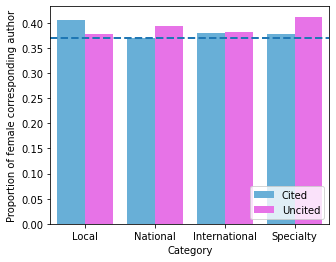

In [0]:
####plotting
import seaborn as sns
import matplotlib.pyplot as plt 

dummy = sep2.copy()
gender = []
  
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    gender.append("female")
  elif dummy['cor_gender'][ind] == 'male' or dummy['cor_gender'][ind] == 'm' or dummy['cor_gender'][ind] == 'M':
    gender.append("male") 

dummy['gender'] = gender

print(dummy['total_count'].min()," hhh ", len(dummy))
print("proportion of female in the entire cited set ",len(dummy[dummy['gender'] == "female"])/len(dummy))

Category = ["Local","Local","National","National","International","International","Specialty", "Specialty"]
Group = ["Cited","Uncited","Cited","Uncited","Cited","Uncited","Cited","Uncited"]
Percent = []

a1 = dummy[dummy['bin_loc'] == 1]
x1 = len(a1[a1['gender'] == "female"])/len(a1)

a1 = dummy[dummy['bin_loc'] == 0]
x2 = len(a1[a1['gender'] == "female"])/len(a1)
print(" percent of female in locally cited group ",x1," and uncited group ",x2)
Percent.append(x1)
Percent.append(x2)



a1 = dummy[dummy['bin_nat'] == 1]
x1=len(a1[a1['gender'] == "female"])/len(a1)

a1 = dummy[dummy['bin_nat'] == 0]
x2=len(a1[a1['gender'] == "female"])/len(a1)
print(" percent of female in nationally cited group ",x1," and uncited group ",x2)
Percent.append(x1)
Percent.append(x2)

a1 = dummy[dummy['bin_int'] == 1]
x1=len(a1[a1['gender'] == "female"])/len(a1)

a1 = dummy[dummy['bin_int'] == 0]
x2=len(a1[a1['gender'] == "female"])/len(a1)
print(" percent of female in internationally cited group ",x1," and uncited group ",x2)
Percent.append(x1)
Percent.append(x2)

a1 = dummy[dummy['bin_sp'] == 1]
x1=len(a1[a1['gender'] == "female"])/len(a1)

a1 = dummy[dummy['bin_sp'] == 0]
x2= len(a1[a1['gender'] == "female"])/len(a1)
print(" percent of female in sp cited group ",x1," and uncited group ",x2)
Percent.append(x1)
Percent.append(x2)

pltdata = pd.DataFrame()
pltdata['Category'] = Category
pltdata['Group'] = Group
pltdata['Percent'] = Percent

print(list(pltdata['Category']))
print(list(pltdata['Group']))
print(list(pltdata['Percent']))

#sns.set_theme(style="ticks", palette="tab10")
fig = plt.figure(figsize =(5, 4))

# Load the example tips dataset

color = ['#56b4e9','#fa60fa','#8de5a1','#ff9f9b']


# Draw a nested boxplot to show bills by day and time
ax = sns.barplot(y="Percent", x="Category",
            hue="Group", palette=color,
            data=pltdata)



'''bars_to_color = [1,2,3,4,5,6,7,8]  # Example: Bars at positions 2, 7, and 11
col = ['#56b4e9','#56b4e9','#fa60fa','#fa60fa','#8de5a1','#8de5a1','#ff9f9b','#ff9f9b']
for i in bars_to_color:
    bars1[i].set_color(col[i-1])'''


'''for bars in ax.containers:
  i = 0
  for bar in bars:
    bar.set_color(color[i])
    i+=1'''

'''hatches = ["", "--- |||","", "--- |||","", "--- |||","", "--- |||"]
# Loop over the bars
i = 0
for bars, hatch in zip(ax.containers, hatches):
    # Set a different hatch for each group of bars
    #i = 0
    for bar in bars:
        bar.set_color(color[i])
        bar.set_hatch(hatch)
        i+=1'''


'''i = 0
for bar in ax.patches:
    # Check if the bar is part of the primary data (not the hue)
    if i < len(custom_colors):
        bar.set_color(color[i])
        bar.set_hatch(hatches[i])
        i += 1'''
      


plt.axhline(y = 0.3705, linewidth = 2, linestyle = "--") #proportion of female corresponding author across the dataset
plt.legend(loc = "lower right")
plt.xticks(fontsize = 10)
plt.ylabel("Proportion of female corresponding author")


<command-621931576738570>:16: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  cited_bars = plt.bar(X_axis + 0.2, cited, 0.4, label='cited', color=['#56b4e9','#fa60fa','#8de5a1','#ff9f9b'], edgecolor='white', hatch='--- |||')
<command-621931576738570>:19: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  legend_patches = [mpatches.Patch(facecolor='grey', edgecolor='white', hatch='--- |||', label='cited'),


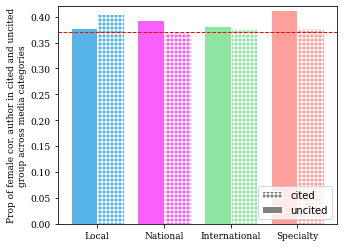

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(5, 4))
cat = ['Local', 'National', 'International', 'Specialty']

uncited = [0.3782, 0.3940, 0.38247, 0.4124]
cited = [0.4054, 0.3703, 0.3791, 0.37733]

X_axis = np.arange(len(cat))

uncited_bars = plt.bar(X_axis - 0.2, uncited, 0.4, label='uncited', color=['#56b4e9','#fa60fa','#8de5a1','#ff9f9b'], edgecolor='white')
cited_bars = plt.bar(X_axis + 0.2, cited, 0.4, label='cited', color=['#56b4e9','#fa60fa','#8de5a1','#ff9f9b'], edgecolor='white', hatch='--- |||')

# Create custom legend patches
legend_patches = [mpatches.Patch(facecolor='grey', edgecolor='white', hatch='--- |||', label='cited'),
                  mpatches.Patch(facecolor='grey', edgecolor='white', label='uncited')]

# Add the legend to the plot
plt.legend(handles=legend_patches, loc='lower right', fontsize = 10)
plt.axhline(y = 0.3705, linewidth = 1, linestyle = "--", color = 'red')

plt.xticks(X_axis, cat, fontsize = 9, fontweight = "normal", fontfamily = "serif")
plt.yticks( fontsize = 9, fontweight = "normal", fontfamily = "serif")
plt.ylabel("Prop of female cor. author in cited and uncited\ngroup across media categories", fontsize = 9, fontweight = "normal", fontfamily = "serif")

plt.ylim(0,0.42)
plt.show()



#### proportion of female cor author papers cited by different types of media

In [0]:
dummy = merged.copy()
G = []
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    G.append("female")
  else:
    G.append("male")
dummy['G'] = G

local = dummy[dummy['type'] == 'local']
national = dummy[dummy['type'] == 'national']
international = dummy[dummy['type'] == 'international']



print("percent of female im local ", len(local[local['G'] == "female"])/len(local))



print("percent of female im national ", len(national[national['G'] == "female"])/len(national))


print("percent of female im international ", len(international[international['G'] == "female"])/len(international))

percent of female im local  0.4047798546613298
percent of female im national  0.36557658952007327
percent of female im international  0.3562172235946778


In [0]:

dummy = sp.copy()
dummy = dummy.drop_duplicates(subset=['media','doi'])
G = []
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    G.append("female")
  else:
    G.append("male")
dummy['G'] = G

print("percent of female in special ",len(dummy[dummy['G'] == "female"])/len(dummy))

percent of female in special  0.3569062854003266


#### proportion of female in top 5% local

In [0]:
dummy = sep2.copy()
#print(dummy.head(5))
#print(len(dummy))
#print(dummy['doi'].nunique())
gender = []
  
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    gender.append("female")
  elif dummy['cor_gender'][ind] == 'male' or dummy['cor_gender'][ind] == 'm' or dummy['cor_gender'][ind] == 'M':
    gender.append("male") 

dummy['gender'] = gender

local = dummy[dummy['local_count'] > 0]
threshold = local['local_count'].quantile(0.95)
top = local[local['local_count'] >= threshold]

print(len(top[top['gender'] == "female"])/len(top))

0.3608847497089639


#### proportion of female in top 5% national

In [0]:
dummy = sep2.copy()
gender = []
  
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    gender.append("female")
  elif dummy['cor_gender'][ind] == 'male' or dummy['cor_gender'][ind] == 'm' or dummy['cor_gender'][ind] == 'M':
    gender.append("male") 

dummy['gender'] = gender

national = dummy[dummy['national_count'] > 0]
threshold = national['national_count'].quantile(0.95)
top = national[national['national_count'] >= threshold]

print(len(top[top['gender'] == "female"])/len(top))

0.3534839325485205


#### proportion of female in top 5% international

In [0]:
dummy = sep2.copy()
gender = []
  
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    gender.append("female")
  elif dummy['cor_gender'][ind] == 'male' or dummy['cor_gender'][ind] == 'm' or dummy['cor_gender'][ind] == 'M':
    gender.append("male") 

dummy['gender'] = gender

inter = dummy[dummy['international_count'] > 0]
threshold = inter['international_count'].quantile(0.95)
top = inter[inter['international_count'] >= threshold]

print(len(top[top['gender'] == "female"])/len(top))

0.30759951749095293


#### proportion of female in top 5% sp

In [0]:
dummy = sep2.copy()
gender = []
  
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    gender.append("female")
  else:
    gender.append("male") 

dummy['gender'] = gender

sp = dummy[dummy['sp_count'] > 0]
threshold = sp['sp_count'].quantile(0.95)
top = sp[sp['sp_count'] >= threshold]

print(len(top[top['gender'] == "female"])/len(top))

0.34947688153898077


#### proportion of female in top 5% overall citation

In [0]:
dummy = sep2.copy()
gender = []
  
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    gender.append("female")
  else:
    gender.append("male") 

dummy['gender'] = gender


threshold = dummy['total_count'].quantile(0.95)
top = dummy[dummy['total_count'] >= threshold]

print(len(top[top['gender'] == "female"])/len(top))

0.359825327510917


Out[27]: (0.0, 0.4)

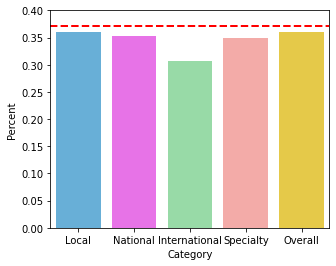

In [0]:
import matplotlib.pyplot as plt 
import seaborn as sns

##plotting
Category = ["Local","National","International","Specialty", "Overall"]
Percent = [0.3608,0.3534,0.3075,0.3494,0.3598]

pltdata = pd.DataFrame()
pltdata['Category'] = Category
pltdata['Percent'] = Percent

#sns.set_theme(style="ticks", palette="tab10")
fig = plt.figure(figsize =(5, 4))

# Load the example tips dataset

color = ['#56b4e9','#fa60fa','#8de5a1','#ff9f9b','#ffd92f']
# Draw a nested boxplot to show bills by day and time
sns.barplot(y="Percent", x="Category",
            palette=color,
            data=pltdata)

plt.axhline(y = 0.3705, linewidth = 2, linestyle = "--", color = "red") #proportion of female corresponding author across the dataset
#plt.legend(loc = "lower right")
plt.xticks(fontsize = 10)
plt.ylim([0,0.40])
#plt.ylabel("Proportion of female corresponding author in top 5% highly cited DOIs across media categories")


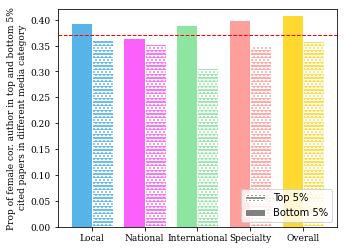

In [0]:
import matplotlib.patches as mpatches

cat = ["Local","National","International","Specialty", "Overall"]
Percent_top = [0.3608,0.3534,0.3075,0.3494,0.3598]
Percent_bot = [0.3944,0.365,0.39,0.40,0.41]

fig = plt.figure(figsize=(5, 4))

X_axis = np.arange(len(cat))

uncited_bars = plt.bar(X_axis - 0.2, Percent_bot, 0.4, label='uncited', color=['#56b4e9','#fa60fa','#8de5a1','#ff9f9b','#ffd92f'], edgecolor='white')
cited_bars = plt.bar(X_axis + 0.2, Percent_top, 0.4, label='cited', color=['#56b4e9','#fa60fa','#8de5a1','#ff9f9b','#ffd92f'], edgecolor='white', hatch='----ooo')

# Create custom legend patches
legend_patches = [mpatches.Patch(facecolor='grey', edgecolor='white', hatch='----ooo', label='Top 5%'),
                  mpatches.Patch(facecolor='grey', edgecolor='white', label='Bottom 5%')]

# Add the legend to the plot
plt.legend(handles=legend_patches, loc='lower right',fontsize = 10)

plt.axhline(y = 0.3705, linewidth = 1, linestyle = "--", color = "red")
plt.xticks(X_axis, cat, fontsize = 9, fontweight = "normal", fontfamily = "serif")
plt.yticks(fontsize = 9, fontweight = "normal", fontfamily = "serif")
#plt.ylabel("Prop of female corresponding author")
plt.ylabel("Prop of female cor. author in top and bottom 5%\n cited papers in different media category", fontsize = 9, fontweight = "normal", fontfamily = "serif")
#plt.xlabel("Prop")
plt.ylim(0,0.42)


plt.show()

#### proportion of female in bottom 5% local, nat,international, sp


In [0]:
dummy = sep2.copy()
gender = []
  
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    gender.append("female")
  else:
    gender.append("male") 

dummy['gender'] = gender

local = dummy[dummy['local_count'] > 0]
threshold = local['local_count'].quantile(0.05)
top = local[local['local_count'] <= threshold]

print("local ",len(top[top['gender'] == "female"])/len(top))


dummy = sep2.copy()
gender = []
  
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    gender.append("female")
  else:
    gender.append("male") 

dummy['gender'] = gender

local = dummy[dummy['national_count'] > 0]
threshold = local['national_count'].quantile(0.05)
top = local[local['national_count'] <= threshold]

print("national ",len(top[top['gender'] == "female"])/len(top))

dummy = sep2.copy()
gender = []
  
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    gender.append("female")
  else:
    gender.append("male") 

dummy['gender'] = gender

local = dummy[dummy['international_count'] > 0]
threshold = local['international_count'].quantile(0.05)
top = local[local['international_count'] <= threshold]

print("international ",len(top[top['gender'] == "female"])/len(top))

dummy = sep2.copy()
gender = []
  
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    gender.append("female")
  else:
    gender.append("male") 

dummy['gender'] = gender

local = dummy[dummy['sp_count'] > 0]
threshold = local['sp_count'].quantile(0.05)
top = local[local['sp_count'] <= threshold]

print("sp ",len(top[top['gender'] == "female"])/len(top))

dummy = sep2.copy()
gender = []
  
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    gender.append("female")
  else:
    gender.append("male") 

dummy['gender'] = gender


threshold = dummy['total_count'].quantile(0.05)
top = dummy[dummy['total_count'] <= threshold]

print("overall ",len(top[top['gender'] == "female"])/len(top))

local  0.3944417357386641
national  0.3652737263414965
international  0.3913624816151892
sp  0.4002261289821979
overall  0.4069266430324516


Out[31]: (0.0, 0.42)

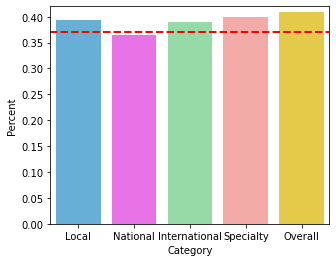

In [0]:
##plotting
import matplotlib.pyplot as plt 
import seaborn as sns

##plotting
Category = ["Local","National","International","Specialty", "Overall"]
Percent = [0.3944,0.365,0.39,0.40,0.41]

pltdata = pd.DataFrame()
pltdata['Category'] = Category
pltdata['Percent'] = Percent

#sns.set_theme(style="ticks", palette="tab10")
fig = plt.figure(figsize =(5, 4))

# Load the example tips dataset
color = ['#56b4e9','#fa60fa','#8de5a1','#ff9f9b','#ffd92f']

# Draw a nested boxplot to show bills by day and time
sns.barplot(y="Percent", x="Category",
            palette=color,
            data=pltdata)

plt.axhline(y = 0.3705, linewidth = 2, linestyle = "--", color = "red") #proportion of female corresponding author across the dataset
#plt.legend(loc = "lower right")
plt.xticks(fontsize = 10)
plt.ylim([0,0.42])
#plt.ylabel("Proportion of female corresponding author in top 5% highly cited DOIs across media categories")

#### gender and ideology

In [0]:
dummy = merged.copy()
G = []
for ind in dummy.index:
  if dummy['cor_gender'][ind] == 'female' or dummy['cor_gender'][ind] == 'f' or dummy['cor_gender'][ind] == 'F':
    #G.append("female")
    G.append("1")
  else:
    #G.append("male")
    G.append("0")
dummy['G'] = G

#print(dummy.dtypes)
dummy['ideology'] = dummy['ideology'].astype(float)
dummy = dummy.dropna(subset = ['ideology'])

In [0]:
q = []
q1,q2,q3 = 0.124,0.25,0.597
for ind in dummy.index:
  if dummy['SJR'][ind] <= q1:
    q.append(0)
  elif dummy['SJR'][ind] > q1 and dummy['SJR'][ind] <= q2:
    q.append(1)
  elif dummy['SJR'][ind] > q2 and dummy['SJR'][ind] <= q3:
    q.append(2)
  else:
    q.append(3)
dummy['q'] = q

Out[10]: <AxesSubplot:>

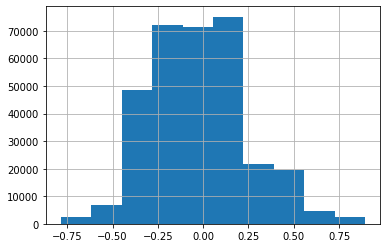

In [0]:
dummy['ideology'].hist()

In [0]:
tmp = pd.DataFrame()
tmp['ideology'] = dummy['ideology']
tmp['G'] = dummy['G']
tmp['year'] = dummy['year']
tmp['Domain_English'] = dummy['Domain_English']
tmp['Field_English'] = dummy['Field_English']
tmp['SubField_English'] = dummy['SubField_English']
tmp['q'] = dummy['q']
tmp['openaccess_status'] = dummy['openaccess_status']

tmp = tmp.dropna(subset = ['ideology'])

#overall: est = -0.0021651, error = 0.0009768, p val = 0.026665 *
#tmp = tmp[tmp['Domain_English'] == 'Applied Sciences'] #est 0.0109223, err = 0.0036194, p val = 0.002550 **
#tmp = tmp[tmp['Domain_English'] == 'Arts & Humanities'] #est =  0.004165, err = 0.007910 , p avl = 0.59851  
#tmp = tmp[tmp['Domain_English'] == 'Economic & Social Sciences'] #est -0.009843, err = 0.003517, p val = 0.005138 **
#tmp = tmp[tmp['Domain_English'] == 'Health Sciences'] #est = -0.002398, err = 0.001197, p val = 0.0452 *
tmp = tmp[tmp['Domain_English'] == 'Natural Sciences'] #est = -0.003674, err = 0.002380, p val = 0.12266

#with sunfield_english as control
#overall: est = -3.68211147e-03, err = 9.91918447e-04, p val =  0.000206 ***
#applied s: est = 6.413e-03, err = 3.695e-03, p val = 0.0826 .
#arts&hum: est = 0.006185, err = 0.008018, p val = 0.44
#econ & social: est = -0.016016, err = 0.003655, p val = 1.18e-05 ***
#health sci: est = -0.0029571, err = 0.0012168, p val = 0.015090 *
#natural sci: est = -0.0059789 , err = 0.002382, p val = 0.012104 *

##overall regression: male gets hitgher value: more positive means more conservative

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('SubField_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('SubField_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('G')
col_2 = ro.vectors.FactorVector(tst_df.rx2('G'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('openaccess_status')
col_2 = ro.vectors.FactorVector(tst_df.rx2('openaccess_status'))
tst_df[col_2_index] = col_2


#print(tst_df)
#pandas2ri.activate()
model = stats.glm("ideology ~ G+year+SubField_English+q+openaccess_status",
                  data=tst_df,family=ro.r('gaussian')) #family=ro.r('gaussian(link="identity")') #family=ro.r('poisson(link="log")')
print(base.summary(model))


Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ...) 
{
    cal <- match.call()
    if (is.character(family)) 
        family <- get(family, mode = "function", envir = parent.frame())
    if (is.function(family)) 
        family <- family()
    if (is.null(family$family)) {
        print(family)
        stop("'family' not recognized")
    }
    if (missing(data)) 
        data <- environment(formula)
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "etastart", "mustart", "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (identical(method, "model.frame")) 
        return(mf)
    if (!is.character(method

In [0]:
import numpy as np
coeffs = base.summary(model).rx2('coefficients')
print(np.array(coeffs))

[[-7.79809274e-02  4.73107958e-02 -1.64826920e+00  9.92984094e-02]
 [-3.68211147e-03  9.91918447e-04 -3.71211109e+00  2.05572022e-04]
 [-1.87453414e-02  1.49144993e-03 -1.25685355e+01  3.20667337e-36]
 [-1.39307288e-02  1.43662350e-03 -9.69685430e+00  3.13104242e-22]
 [-8.17314509e-03  1.44374219e-03 -5.66108351e+00  1.50546419e-08]
 [ 1.94531693e-02  1.55222581e-03  1.25324352e+01  5.05779314e-36]
 [ 7.56546422e-02  4.56063955e-02  1.65886037e+00  9.71448967e-02]
 [ 2.98965824e-02  4.34615294e-02  6.87886111e-01  4.91524995e-01]
 [ 7.86891668e-02  4.71761572e-02  1.66798594e+00  9.53194820e-02]
 [ 1.39733093e-02  4.17648104e-02  3.34571356e-01  7.37948671e-01]
 [ 1.45992224e-01  4.16807137e-02  3.50263254e+00  4.60746363e-04]
 [ 4.73375988e-02  4.18130914e-02  1.13212387e+00  2.57583196e-01]
 [-4.47627556e-03  1.58098657e-01 -2.83131789e-02  9.77412387e-01]
 [ 1.53290790e-01  4.17279820e-02  3.67357304e+00  2.39220633e-04]
 [ 3.85406401e-02  4.33518136e-02  8.89020249e-01  3.73992855e

In [0]:
a = stats.confint_glm(model)
#confint(model)

R[write to console]: Waiting for profiling to be done...



In [0]:
print(a)

                                                             2.5 %       97.5 %
(Intercept)                                           -0.270322363  0.199280070
G1                                                    -0.010649135 -0.001308638
year2019                                              -0.004930915  0.008202793
year2020                                               0.002977001  0.015992692
year2021                                               0.008817089  0.021611811
year2022                                               0.026163530  0.040153940
SubField_Englishanalytical chemistry                  -0.067429467  0.019743199
SubField_Englishapplied mathematics                   -0.442599080  0.026572358
SubField_Englishapplied physics                       -0.173130718 -0.087806568
SubField_Englishastronomy & astrophysics              -0.050829960  0.029944011
SubField_Englishchemical physics                      -0.188674460 -0.100961229
SubField_Englishecology                 

In [0]:
print(stats.confint(model))

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<command-1342674571194513> in <cell line: 1>()
----> 1 print(stats.confint(model))

AttributeError: module 'MASS' has no attribute 'confint'

### Weighted Regression

In [0]:
a = pd.DataFrame()
a['doi'] = dummy['doi']
a['ideology'] = dummy['ideology']
new_df = a.groupby('doi')['ideology'].mean().reset_index()
'''print(len(dummy))
print(dummy['doi'].nunique())
print(len(new_df))'''
x = dummy.copy(deep = True)
x = x.drop(columns = ['ideology'])
x = x.drop_duplicates(subset = ['doi'])
print(len(x))

ideo = x.merge(new_df, on = 'doi', how = "inner")
print(len(ideo))
#print(ideo.head(5))

61269
61269


In [0]:
ideo = dummy.copy(deep = True)
print(len(ideo))
tmp = pd.DataFrame()
tmp['ideology'] = ideo['ideology']
tmp['G'] = ideo['G']
tmp['year'] = ideo['year']
tmp['Domain_English'] = ideo['Domain_English']
tmp['Field_English'] = ideo['Field_English']
tmp['SubField_English'] = ideo['SubField_English']
tmp['q'] = ideo['q']
tmp['doi'] = ideo['doi']

tmp = tmp.dropna(subset = ['ideology'])

tmp['row_count'] = tmp.groupby('doi')['doi'].transform('count')
tmp['row_count'] = 1/tmp['row_count']

#overall: est = -2.62089085e-03, err = 9.00419048e-04, p val = 0.003606 ** 
#tmp = tmp[tmp['Domain_English'] == 'Applied Sciences'] #est -0.0044740, err = 0.0030171 , p val = 0.138123
#tmp = tmp[tmp['Domain_English'] == 'Arts & Humanities'] #est =  0.015968, err = 0.007189 , p avl =  0.026375 *  
#tmp = tmp[tmp['Domain_English'] == 'Economic & Social Sciences'] #est -0.014963, err = 0.003239, p val = 3.85e-06 ***
#tmp = tmp[tmp['Domain_English'] == 'Health Sciences'] #est = -0.0005960, err = 0.0011718, p val = 0.611018
tmp = tmp[tmp['Domain_English'] == 'Natural Sciences'] #est = -0.0043780, err = 0.0018455, p val = 0.017680 * 


##overall regression: male gets hitgher value: more positive means more conservative

with localconverter(ro.default_converter + pandas2ri.converter):
  tst_df = ro.conversion.py2rpy(tmp)

col_2_index = list(tst_df.colnames).index('year')
col_2 = ro.vectors.FactorVector(tst_df.rx2('year'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('q')
col_2 = ro.vectors.FactorVector(tst_df.rx2('q'))
tst_df[col_2_index] = col_2


col_2_index = list(tst_df.colnames).index('SubField_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('SubField_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('Field_English')
col_2 = ro.vectors.FactorVector(tst_df.rx2('Field_English'))
tst_df[col_2_index] = col_2

col_2_index = list(tst_df.colnames).index('G')
col_2 = ro.vectors.FactorVector(tst_df.rx2('G'))
tst_df[col_2_index] = col_2


#print(tst_df)
#pandas2ri.activate()
model = stats.glm("ideology ~ G+year+SubField_English+q",
                  data=tst_df,weights = tst_df.rx2('row_count'),family=ro.r('gaussian')) #family=ro.r('gaussian(link="identity")') #family=ro.r('poisson(link="log")')
print(base.summary(model))

325133

Call:
(function (formula, family = gaussian, data, weights, subset, 
    na.action, start = NULL, etastart, mustart, offset, control = list(...), 
    model = TRUE, method = "glm.fit", x = FALSE, y = TRUE, singular.ok = TRUE, 
    contrasts = NULL, ...) 
{
    cal <- match.call()
    if (is.character(family)) 
        family <- get(family, mode = "function", envir = parent.frame())
    if (is.function(family)) 
        family <- family()
    if (is.null(family$family)) {
        print(family)
        stop("'family' not recognized")
    }
    if (missing(data)) 
        data <- environment(formula)
    mf <- match.call(expand.dots = FALSE)
    m <- match(c("formula", "data", "subset", "weights", "na.action", 
        "etastart", "mustart", "offset"), names(mf), 0L)
    mf <- mf[c(1L, m)]
    mf$drop.unused.levels <- TRUE
    mf[[1L]] <- quote(stats::model.frame)
    mf <- eval(mf, parent.frame())
    if (identical(method, "model.frame")) 
        return(mf)
    if (!is.character

In [0]:
import numpy as np
coeffs = base.summary(model).rx2('coefficients')
print(np.array(coeffs))

[[-9.93014413e-02  2.99640978e-02 -3.31401406e+00  9.19769321e-04]
 [-2.62089085e-03  9.00419048e-04 -2.91074568e+00  3.60591850e-03]
 [-1.97011770e-03  1.29793315e-03 -1.51788841e+00  1.29043504e-01]
 [-2.51068431e-03  1.29117887e-03 -1.94448993e+00  5.18372605e-02]
 [-9.15292693e-04  1.28623985e-03 -7.11603434e-01  4.76710891e-01]
 [ 8.74766371e-03  1.46605407e-03  5.96680838e+00  2.42188391e-09]
 [-2.14344441e-02  2.88799879e-02 -7.42190204e-01  4.57972639e-01]
 [-2.44327291e-02  2.50184247e-02 -9.76589429e-01  3.28773182e-01]
 [ 3.75233455e-02  2.82295102e-02  1.32922410e+00  1.83774978e-01]
 [-1.80150951e-02  2.18723537e-02 -8.23646841e-01  4.10140857e-01]
 [ 7.25635766e-02  2.26428306e-02  3.20470430e+00  1.35214355e-03]
 [-4.44746786e-02  2.20537758e-02 -2.01664690e+00  4.37331959e-02]
 [ 1.12351813e-02  1.05985377e-01  1.06006900e-01  9.15576943e-01]
 [ 8.22896988e-02  2.26839448e-02  3.62766263e+00  2.86042391e-04]
 [-6.48724093e-02  2.43928822e-02 -2.65948110e+00  7.82649573e

In [0]:
a = pd.DataFrame()
a['doi'] = ['a','a','a','b','c','d']
a['value'] = [1,2,3,4,5,6]
a['year'] = [21,22,23,24,25,26]
new_df = a.groupby('doi')['value'].mean().reset_index()
#print(new_df)

a['row_count'] = a.groupby('doi')['doi'].transform('count')
a['row_count'] = 1/a['row_count']
print(a)

  doi  value  year  row_count
0   a      1    21   0.333333
1   a      2    22   0.333333
2   a      3    23   0.333333
3   b      4    24   1.000000
4   c      5    25   1.000000
5   d      6    26   1.000000


In [0]:
##https://www.tutorialspoint.com/how-to-find-the-95-confidence-interval-for-the-glm-model-in-r - the glm CI matches 
##https://rviews.rstudio.com/2022/05/25/calling-r-from-python-with-rpy2/ 
#https://www.reddit.com/r/Rlanguage/comments/9tfueq/is_there_a_way_to_easily_generate_odds_ratios_and/ 